Step 1: Get video data from a Youtube channel

In [2]:
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
import json
from IPython.display import JSON
from dotenv import load_dotenv
from dateutil import parser
import isodate
import os 

In [3]:
# Loading API Key 
def configure():
    load_dotenv(dotenv_path=r"C:\Users\Brian Nguyen\Desktop\projects\keys\.env")

configure() 

# Define API service name and version
api_service_name = "youtube"
api_version = "v3"

# Get creds and create an API client
youtube = build(
    api_service_name, api_version, developerKey=os.getenv('api_key')  
)

In [4]:
channel_ids = ['veritasium',
               # more channels here
               ]

def get_channel_stats(youtube, channel_ids):

  all_data = []

  request = youtube.channels().list(
      part="snippet,contentDetails,statistics",
      forHandle=','.join(channel_ids)
  )
  response = request.execute()

  # loop through items
  for item in response['items']:
    data = {'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalViews': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
            }
    all_data.append(data)

  return(pd.DataFrame(all_data))

In [5]:
# Getting Veritasium's overall channel stats
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,subscribers,views,totalViews,playlistId
0,Veritasium,17400000,3134898368,431,UUHnyfMqiRRG1u-2MsSQLbXA


In [ ]:
# Function to get all videos the channel(s) has ever uploaded

playlist_id = "UUHnyfMqiRRG1u-2MsSQLbXA" # Update this if you have more than 1 channel

def get_video_ids(youtube, playlist_id):

  video_ids = []

  request = youtube.playlistItems().list(
      part="snippet,contentDetails",
      playlistId=playlist_id,
      maxResults = 50
  )

  response = request.execute()

  for item in response ['items']:
    video_ids.append(item['contentDetails']['videoId'])

  next_page_token = response.get('nextPageToken')
  while next_page_token is not None:
      request = youtube.playlistItems().list(
          part='contentDetails',
          playlistId = playlist_id,
          maxResults = 50,
          pageToken = next_page_token)
      response = request.execute()

      for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

      next_page_token = response.get('nextPageToken')

  return video_ids

In [7]:
# Storing video_ids 
video_ids = get_video_ids(youtube, playlist_id)

# Counting the # of uploaded videos
len(video_ids)

431

In [8]:
# Function to return video statistics. Will later save this as a dataframe called 'video_df'
def get_video_details(youtube, video_ids):

  all_video_info = []

  for i in range(0, len(video_ids), 50):
    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=','.join(video_ids[i:i+50])
    )
    response = request.execute()

    for video in response['items']:
      stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                      'statistics': ['viewCount', 'likeCount', 'favoriteCount', 'commentCount'],
                      'contentDetails': ['duration', 'definition', 'caption']
                      }
      video_info = {}
      video_info['video_id'] = video['id']

      for k in stats_to_keep.keys():
        for v in stats_to_keep[k]:
          try:
            video_info[v] = video[k][v]
          except:
            video_info[v] = None

      all_video_info.append(video_info)

  return pd.DataFrame(all_video_info)

In [9]:
# Reviewing the dataframe
video_df = get_video_details(youtube, video_ids)
video_df.head(5) 

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption
0,qJZ1Ez28C-A,Veritasium,Something Strange Happens When You Trust Quant...,Does light take all possible paths at the same...,"[veritasium, science, physics, math, quantum m...",2025-03-05T02:22:56Z,76676,6771,0,618,PT33M37S,hd,true
1,dFVrncgIvos,Veritasium,The Google Interview Question Everyone Gets Wrong,Are you smart enough to solve this Google inte...,"[veritasium, science, physics, Veritasium, eng...",2025-02-18T16:03:35Z,5498649,158185,0,16328,PT20M13S,hd,true
2,mqo1lQL59VI,Veritasium,This Is The Perfect Bowling Strategy,What is the optimal strategy for bowling? #sci...,"[veritasium, science, physics, math, bowling, ...",2025-02-14T16:49:48Z,1107573,52557,0,555,PT2M6S,hd,false
3,P_fHJIYENdI,Veritasium,The Most Useful Thing AI Has Ever Done,The biggest problems in the world might be sol...,"[veritasium, science, physics, nobel prize, pr...",2025-02-10T14:03:41Z,7304094,262333,0,11175,PT24M52S,hd,true
4,88bMVbx1dzM,Veritasium,What if you just keep zooming in?,Here’s what happens when you just keep zooming...,"[veritasium, science, physics]",2025-02-05T15:02:34Z,10018716,215538,0,8002,PT21M29S,hd,true


Step 2: Perform EDA to understand the following..
* Views per video
* Likes and comments vs. views
* Title length vs. views
* Video duration
* Video upload schedules

In [10]:
# Understanding feature dtypes 
video_df.dtypes

video_id         object
channelTitle     object
title            object
description      object
tags             object
publishedAt      object
viewCount        object
likeCount        object
favoriteCount    object
commentCount     object
duration         object
definition       object
caption          object
dtype: object

In [11]:
# Casting numeric features
numeric_cols = ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

# Casting datetime features
video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt'])

In [12]:
# Checking dtypes after changes
video_df.dtypes

video_id                      object
channelTitle                  object
title                         object
description                   object
tags                          object
publishedAt      datetime64[ns, UTC]
viewCount                    float64
likeCount                    float64
favoriteCount                float64
commentCount                 float64
duration                      object
definition                    object
caption                       object
dtype: object

In [13]:
# Checking for nulls
video_df.isnull().any()

video_id         False
channelTitle     False
title            False
description      False
tags              True
publishedAt      False
viewCount        False
likeCount         True
favoriteCount    False
commentCount     False
duration         False
definition       False
caption          False
dtype: bool

In [ ]:
# Adding features to help with analysis

# Convert duration to seconds (handling missing values)
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds() if pd.notna(x) else None)

# Convert publishedAt to datetime (handling missing values)
video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt'], errors='coerce')

# Extract the day of the week
video_df['publishDayName'] = video_df['publishedAt'].dt.day_name()

# Fix tag count calculation
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None or isinstance(x, float) else len(x))

In [ ]:
# Checking changes to duration feature 
video_df.head(5)

# Verifying feature dtypes
# video_df.dtypes # uncomment this line to verify

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption,durationSecs,publishDayName,tagCount
0,qJZ1Ez28C-A,Veritasium,Something Strange Happens When You Trust Quant...,Does light take all possible paths at the same...,"[veritasium, science, physics, math, quantum m...",2025-03-05 02:22:56+00:00,76676.0,6771.0,0.0,618.0,PT33M37S,hd,true,2017.0,Wednesday,29
1,dFVrncgIvos,Veritasium,The Google Interview Question Everyone Gets Wrong,Are you smart enough to solve this Google inte...,"[veritasium, science, physics, Veritasium, eng...",2025-02-18 16:03:35+00:00,5498649.0,158185.0,0.0,16328.0,PT20M13S,hd,true,1213.0,Tuesday,29
2,mqo1lQL59VI,Veritasium,This Is The Perfect Bowling Strategy,What is the optimal strategy for bowling? #sci...,"[veritasium, science, physics, math, bowling, ...",2025-02-14 16:49:48+00:00,1107573.0,52557.0,0.0,555.0,PT2M6S,hd,false,126.0,Friday,8
3,P_fHJIYENdI,Veritasium,The Most Useful Thing AI Has Ever Done,The biggest problems in the world might be sol...,"[veritasium, science, physics, nobel prize, pr...",2025-02-10 14:03:41+00:00,7304094.0,262333.0,0.0,11175.0,PT24M52S,hd,true,1492.0,Monday,18
4,88bMVbx1dzM,Veritasium,What if you just keep zooming in?,Here’s what happens when you just keep zooming...,"[veritasium, science, physics]",2025-02-05 15:02:34+00:00,10018716.0,215538.0,0.0,8002.0,PT21M29S,hd,true,1289.0,Wednesday,3


In [42]:
video_df.shape

(431, 16)

In [46]:
video_df.describe()

,viewCount,likeCount,favoriteCount,commentCount,durationSecs,tagCount
count,4.310000e+02,4.300000e+02,431.0,431.000000,431.000000,431.000000
mean,7.277862e+06,1.863681e+05,0.0,9795.531323,616.631090,12.976798
std,1.084627e+07,2.599921e+05,0.0,13692.530127,564.858221,7.839341
min,4.182800e+04,3.990000e+02,0.0,12.000000,23.000000,0.000000
25%,1.262602e+06,2.412150e+04,0.0,1936.500000,214.500000,6.000000
50%,3.930782e+06,1.037390e+05,0.0,5030.000000,440.000000,12.000000
75%,8.611506e+06,2.460108e+05,0.0,11247.000000,888.500000,19.000000
max,1.053881e+08,2.591984e+06,0.0,114050.000000,5240.000000,39.000000


C:\Users\Brian Nguyen\AppData\Local\Temp\ipykernel_24472\195361919.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_yticklabels(ax.get_yticklabels()) #, rotation=90)


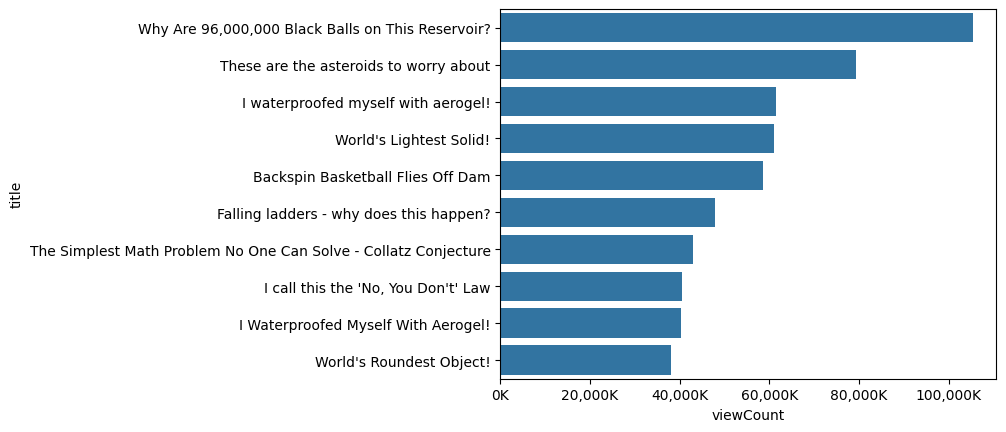

In [33]:
# Creating a bar chart to see the top 10 videos by view count
ax = sns.barplot(y = 'title', x = 'viewCount', orient = 'h', data = video_df.sort_values('viewCount', ascending = False)[0:10])
plot = ax.set_yticklabels(ax.get_yticklabels()) #, rotation=90)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

C:\Users\Brian Nguyen\AppData\Local\Temp\ipykernel_24472\3445718378.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_yticklabels(ax.get_yticklabels()) #, rotation=90)


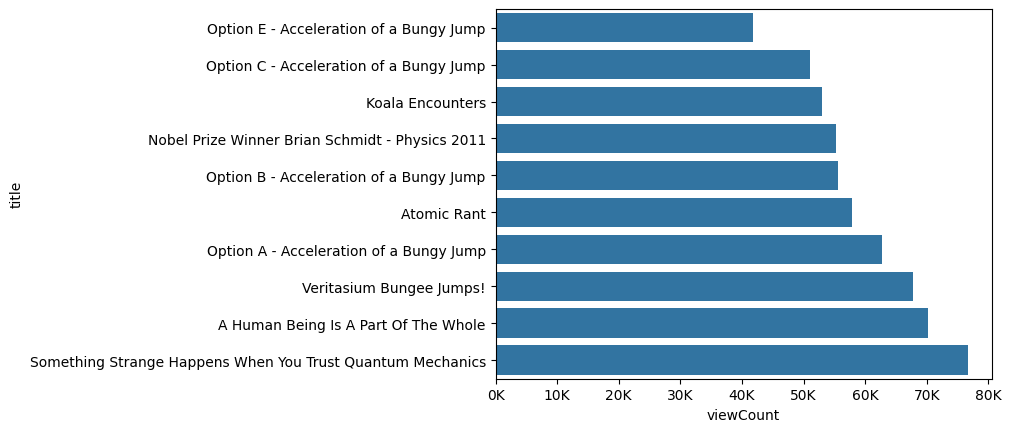

In [ ]:
# Creating a bar chart to see the Bottom 10 videos by view count
ax = sns.barplot(y = 'title', x = 'viewCount', orient = 'h', data = video_df.sort_values('viewCount', ascending = True)[0:10])
plot = ax.set_yticklabels(ax.get_yticklabels()) #, rotation=90)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

C:\Users\Brian Nguyen\AppData\Local\Temp\ipykernel_24472\1841006338.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


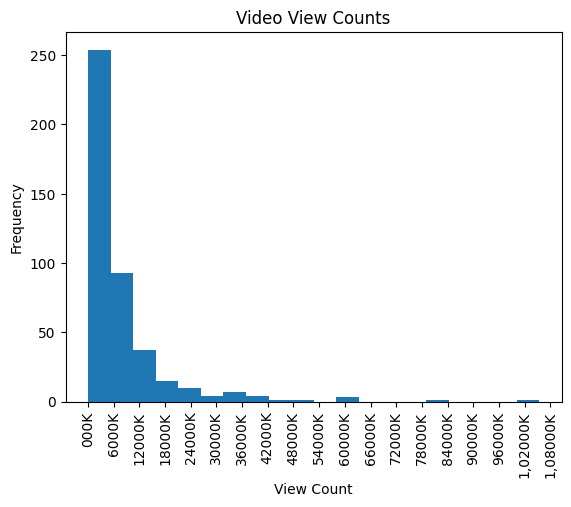

In [58]:
# Define the number of bins
num_bins = 20  

# Create the histogram
ax = video_df['viewCount'].plot(
    kind='hist',
    bins=num_bins,
    title='Video View Counts'
)

# Set x-axis label
ax.set_xlabel('View Count')

# Set x-axis ticks to match the number of bins
ax.xaxis.set_major_locator(plt.MaxNLocator(num_bins))

# Format x-axis to show tick labels in 100K format
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/100000):,}00K'))

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Show plot
plt.show()

Text(0.5, 0, 'View Count')

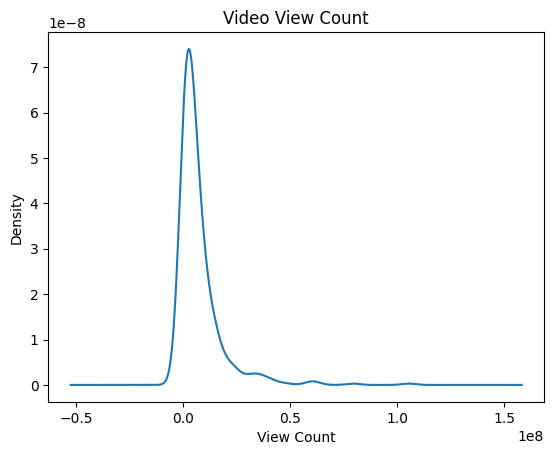

In [ ]:
# Kernel Density Estimation (KDE), or a graph that shows how data is distributed
ax = video_df['viewCount'].plot(kind='kde',
                                title='Video View Count')
ax.set_xlabel('View Count')

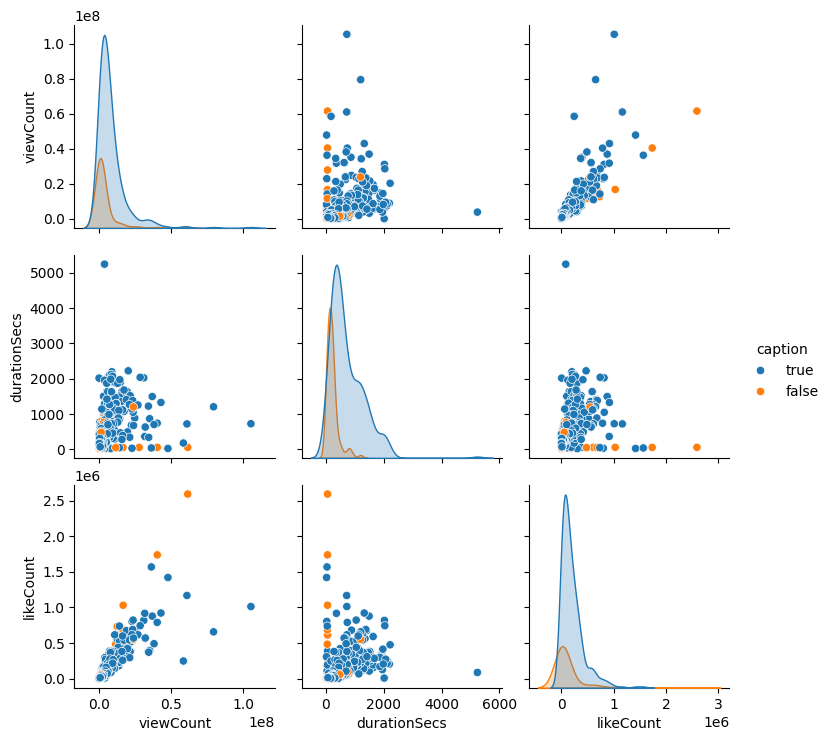

In [ ]:
# Pairplot to compare multiple features

sns.pairplot(video_df, vars = ['viewCount', 
                               'durationSecs', 
                               'likeCount'],
             hue='caption')
plt.show()

<Axes: >

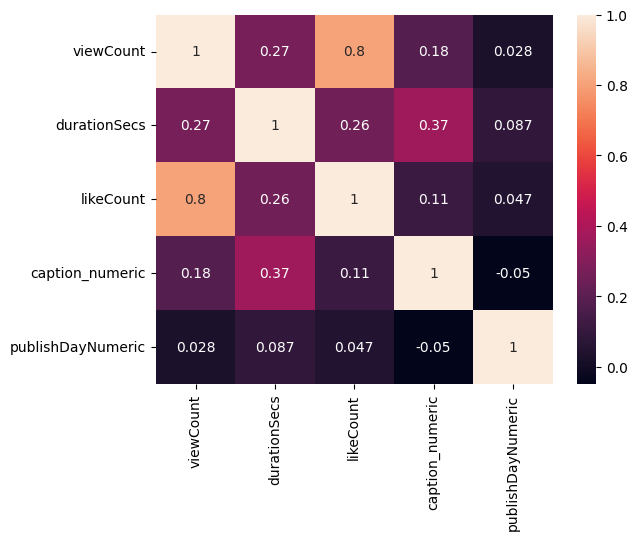

In [71]:
# Seeing correlations between features (tabular view)

# Convert 'caption' to numeric (0 = False, 1 = True)
video_df['caption_numeric'] = video_df['caption'].map({'true': 1, 'false': 0})

# Convert 'publishDayName' to numeric (Monday = 0, ..., Sunday = 6)
video_df['publishDayNumeric'] = pd.Categorical(video_df['publishDayName'], 
                                               categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                               ordered=True).codes

# Compute correlations
df_corr = video_df[['viewCount', 'durationSecs', 'likeCount', 'caption_numeric', 'publishDayNumeric']].dropna().corr()

# Seeing correlations between features (heatmap view)
sns.heatmap(df_corr, annot=True)